
=== Training tokenizer (vocab=2000, min_freq=2) ===



Saved → ../data/patroberta-tokenizers/vs2000
Train: avg=610.39, p95=1146, unk_rate=0.0000
Val  : avg=605.74, p95=1147, unk_rate=0.0000

=== Training tokenizer (vocab=4000, min_freq=2) ===



Saved → ../data/patroberta-tokenizers/vs4000
Train: avg=540.48, p95=1013, unk_rate=0.0000
Val  : avg=537.36, p95=1018, unk_rate=0.0000

=== Training tokenizer (vocab=8000, min_freq=2) ===



Saved → ../data/patroberta-tokenizers/vs8000
Train: avg=502.05, p95=943, unk_rate=0.0000
Val  : avg=500.47, p95=949, unk_rate=0.0000

=== Training tokenizer (vocab=16000, min_freq=2) ===



Saved → ../data/patroberta-tokenizers/vs16000
Train: avg=484.09, p95=912, unk_rate=0.0000
Val  : avg=482.39, p95=912, unk_rate=0.0000

=== Training tokenizer (vocab=24000, min_freq=2) ===



Saved → ../data/patroberta-tokenizers/vs24000
Train: avg=478.68, p95=901, unk_rate=0.0000
Val  : avg=477.49, p95=901, unk_rate=0.0000

=== Training tokenizer (vocab=32000, min_freq=

,vocab_size,train_avg_len,train_p95_len,train_unk_rate,val_avg_len,val_p95_len,val_unk_rate
0,2000,610.3912,1146.0,0.0,605.742,1147.0,0.0
1,4000,540.4801,1013.0,0.0,537.364,1018.0,0.0
2,8000,502.0487,943.0,0.0,500.470,949.0,0.0
3,16000,484.0917,912.0,0.0,482.389,912.0,0.0
4,24000,478.6754,901.0,0.0,477.485,901.0,0.0
5,32000,476.1834,897.0,0.0,475.469,897.0,0.0
6,50000,473.7836,893.0,0.0,473.309,897.0,0.0



Wrote: ../data/patroberta-tokenizers/summary.csv
Wrote: ../data/patroberta-tokenizers/summary.json


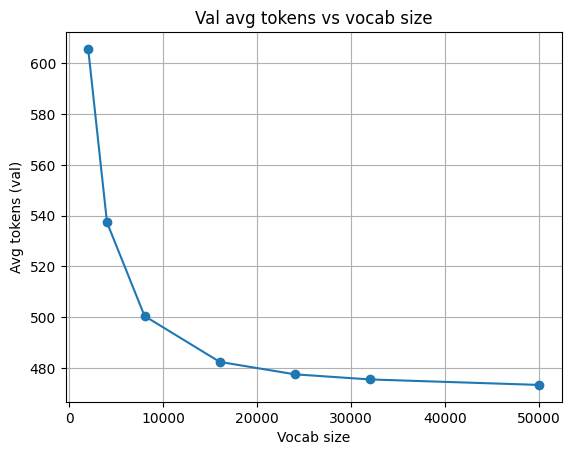

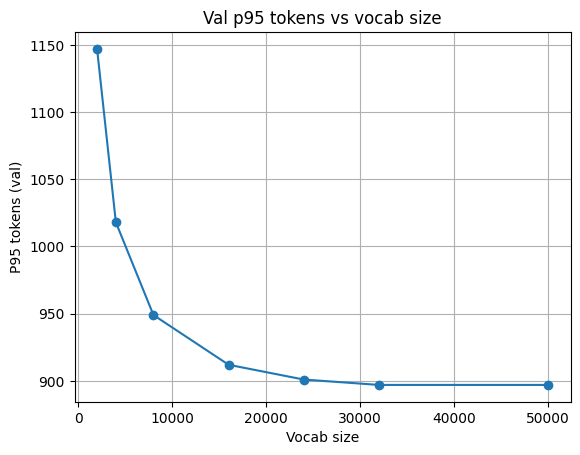

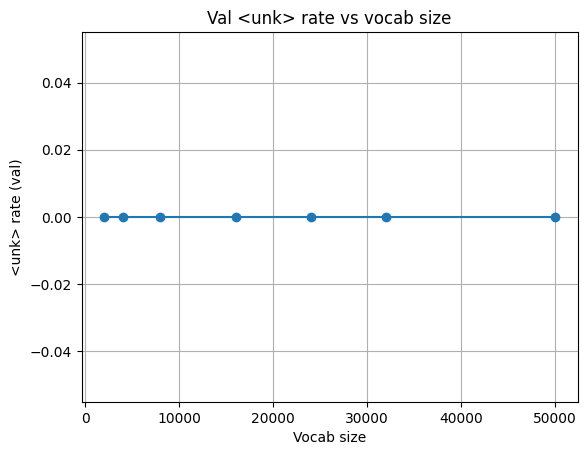


--- Sample encodings @ vocab=2000 ---
LiFePO4              → ['<s>', 'ĠL', 'i', 'F', 'e', 'P', 'O', '4', '</s>']  (len=9)
RNA-seq              → ['<s>', 'ĠR', 'N', 'A', '-', 'se', 'q', '</s>']  (len=8)
μm                   → ['<s>', 'ĠÎ', '¼', 'm', '</s>']  (len=5)
NaCl                 → ['<s>', 'ĠN', 'a', 'C', 'l', '</s>']  (len=6)
poly(ethylene)       → ['<s>', 'Ġpoly', '(', 'ethyl', 'ene', ')', '</s>']  (len=7)
<REFNUM>             → ['<s>', 'Ġ<', 'REFNUM', '>', '</s>']  (len=5)

--- Sample encodings @ vocab=4000 ---
LiFePO4              → ['<s>', 'ĠL', 'i', 'F', 'e', 'P', 'O', '4', '</s>']  (len=9)
RNA-seq              → ['<s>', 'ĠR', 'NA', '-', 'se', 'q', '</s>']  (len=7)
μm                   → ['<s>', 'ĠÎ¼m', '</s>']  (len=3)
NaCl                 → ['<s>', 'ĠN', 'a', 'C', 'l', '</s>']  (len=6)
poly(ethylene)       → ['<s>', 'Ġpoly', '(', 'ethylene', ')', '</s>']  (len=6)
<REFNUM>             → ['<s>', 'Ġ<', 'REFNUM', '>', '</s>']  (len=5)

--- Sample encodings @ vocab=8000 ---
L

In [ ]:
# patRoBERTa Tokenizer Trainer (Jupyter-friendly, with metrics & simple viz)
# - Trains byte-level BPE tokenizers over a vocab sweep
# - Logs avg/p95 tokenized lengths and <unk> rate on train/val
# - Saves HF-compatible artifacts per vocab size
# - Visualizes results inline

import json, math, random
from pathlib import Path
from statistics import mean
from typing import List, Dict
from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import Sequence, NFKC
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.processors import TemplateProcessing

# -------------------
# CONFIG (edit here)
# -------------------
TRAIN_TXT = "../data/ep-b1-claim1-cpc_train.txt"
VAL_TXT   = "../data/ep-b1-claim1-cpc_val.txt"
OUT_DIR   = "../data/patroberta-tokenizers"   # will create subfolders e.g. vs32000
VOCAB_SIZES = [2000, 4000, 8000, 16000, 24000, 32000, 50000]               # sweep
MIN_FREQ   = 2
SAMPLE_TRAIN = None     # number of lines to sample for quick metrics (None = use all)
SAMPLE_VAL   = 1000
SEED = 42

# -------------------
# Utilities
# -------------------
def read_lines(path: str, limit: int | None = None) -> List[str]:
    out = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            out.append(line.rstrip("\n"))
            if limit and len(out) >= limit:
                break
    return out

def percentile(xs: List[int], p: float) -> int:
    if not xs: return 0
    xs = sorted(xs); k = (len(xs)-1)*p
    a = math.floor(k); b = math.ceil(k)
    if a == b: return xs[int(k)]
    return int(xs[a] + (xs[b]-xs[a])*(k-a))

def encode_lengths(tok: Tokenizer, lines: List[str]) -> Dict[str, float]:
    unk_id = tok.token_to_id("<unk>")
    lens, unk_tokens = [], 0
    for s in lines:
        enc = tok.encode(s)
        ids = enc.ids
        lens.append(len(ids))
        if unk_id is not None:
            unk_tokens += sum(1 for i in ids if i == unk_id)
    total_tokens = max(1, sum(lens))
    return {
        "n_samples": len(lines),
        "avg_len": float(mean(lens)) if lens else 0.0,
        "p95_len": float(percentile(lens, 0.95)),
        "unk_rate": float(unk_tokens / total_tokens)
    }

def save_hf_artifacts(tok: Tokenizer, outdir: Path):
    outdir.mkdir(parents=True, exist_ok=True)
    tok.save(str(outdir / "tokenizer.json"))
    # minimal HF files
    (outdir / "special_tokens_map.json").write_text(json.dumps({
        "unk_token": "<unk>", "bos_token": "<s>", "eos_token": "</s>",
        "pad_token": "<pad>", "mask_token": "<mask>"
    }, indent=2))
    (outdir / "tokenizer_config.json").write_text(json.dumps({
        "add_prefix_space": True, "model_max_length": 512
    }, indent=2))
    # Export merges/vocab for broader compatibility (best-effort)
    try:
        vocab = tok.get_vocab()  # token->id
        inv = {i:t for t,i in vocab.items()}
        with open(outdir / "vocab.json", "w", encoding="utf-8") as vf:
            ordered = [inv[i] for i in range(len(inv))]
            json.dump({t:i for i,t in enumerate(ordered)}, vf, ensure_ascii=False)
        merges = tok.model.get_merges()
        if merges:
            with open(outdir / "merges.txt", "w", encoding="utf-8") as mf:
                mf.write("#version: 0.2\n")
                for a,b in merges:
                    mf.write(f"{a} {b}\n")
    except Exception:
        pass  # tokenizer.json is typically enough for RobertaTokenizerFast

def train_one(train_file: str, vocab_size: int, min_freq: int, specials: list[str]) -> Tokenizer:
    tok = Tokenizer(BPE(unk_token="<unk>"))
    tok.normalizer = Sequence([NFKC()])
    tok.pre_tokenizer = ByteLevel(add_prefix_space=True)
    tok.decoder = ByteLevelDecoder()
    trainer = BpeTrainer(vocab_size=vocab_size, min_frequency=min_freq, special_tokens=specials)
    tok.train(files=[train_file], trainer=trainer)
    tok.post_processor = TemplateProcessing(
        single="<s> $A </s>",
        pair="<s> $A </s> </s> $B </s>",
        special_tokens=[("<s>", tok.token_to_id("<s>")), ("</s>", tok.token_to_id("</s>"))],
    )
    return tok

# -------------------
# Run sweep
# -------------------
random.seed(SEED)
outbase = Path(OUT_DIR); outbase.mkdir(parents=True, exist_ok=True)
specials = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]

# Sample for quick metrics
train_lines = read_lines(TRAIN_TXT)
val_lines   = read_lines(VAL_TXT)
if SAMPLE_TRAIN and len(train_lines) > SAMPLE_TRAIN:
    train_lines = random.sample(train_lines, SAMPLE_TRAIN)
if SAMPLE_VAL and len(val_lines) > SAMPLE_VAL:
    val_lines = random.sample(val_lines, SAMPLE_VAL)

rows = []
for vs in VOCAB_SIZES:
    print(f"\n=== Training tokenizer (vocab={vs}, min_freq={MIN_FREQ}) ===")
    tok = train_one(TRAIN_TXT, vs, MIN_FREQ, specials)

    m_train = encode_lengths(tok, train_lines)
    m_val   = encode_lengths(tok, val_lines)

    model_dir = outbase / f"vs{vs}"
    save_hf_artifacts(tok, model_dir)
    (model_dir / "meta.json").write_text(json.dumps({
        "vocab_size": vs, "min_freq": MIN_FREQ, "specials": specials,
        "train_file": TRAIN_TXT, "val_file": VAL_TXT,
        "metrics": {"train": m_train, "val": m_val}
    }, indent=2))
    print(f"Saved → {model_dir}")
    print(f"Train: avg={m_train['avg_len']:.2f}, p95={m_train['p95_len']:.0f}, unk_rate={m_train['unk_rate']:.4f}")
    print(f"Val  : avg={m_val['avg_len']:.2f}, p95={m_val['p95_len']:.0f}, unk_rate={m_val['unk_rate']:.4f}")

    rows.append({
        "vocab_size": vs,
        "train_avg_len": m_train["avg_len"],
        "train_p95_len": m_train["p95_len"],
        "train_unk_rate": m_train["unk_rate"],
        "val_avg_len": m_val["avg_len"],
        "val_p95_len": m_val["p95_len"],
        "val_unk_rate": m_val["unk_rate"],
    })

# -------------------
# Tabulate + save summary
# -------------------
df = pd.DataFrame(rows).sort_values("vocab_size")
display(df)

summary_csv = outbase / "summary.csv"
summary_json = outbase / "summary.json"
df.to_csv(summary_csv, index=False)
summary_json.write_text(json.dumps(rows, indent=2))
print(f"\nWrote: {summary_csv}\nWrote: {summary_json}")

# -------------------
# Plots (one metric per plot)
# -------------------
plt.figure()
plt.plot(df["vocab_size"], df["val_avg_len"], marker="o")
plt.title("Val avg tokens vs vocab size")
plt.xlabel("Vocab size"); plt.ylabel("Avg tokens (val)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df["vocab_size"], df["val_p95_len"], marker="o")
plt.title("Val p95 tokens vs vocab size")
plt.xlabel("Vocab size"); plt.ylabel("P95 tokens (val)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df["vocab_size"], df["val_unk_rate"], marker="o")
plt.title("Val <unk> rate vs vocab size")
plt.xlabel("Vocab size"); plt.ylabel("<unk> rate (val)")
plt.grid(True)
plt.show()

# -------------------
# Quick manual tokenization checks (edit terms as needed)
# -------------------
check_terms = ["LiFePO4", "RNA-seq", "μm", "NaCl", "poly(ethylene)", "<REFNUM>"]
for vs in VOCAB_SIZES:
    print(f"\n--- Sample encodings @ vocab={vs} ---")
    tok = Tokenizer.from_file(str((outbase / f"vs{vs}" / "tokenizer.json")))
    for term in check_terms:
        ids = tok.encode(term).ids
        toks = tok.encode(term).tokens
        print(f"{term:20s} → {toks}  (len={len(ids)})")


# Full training with 8k on all claims


=== Training tokenizer (vocab=8000, min_freq=2) ===



Saved → ../data/2-tokenizers/vs8000
Train: avg=139.11, p95=574, unk_rate=0.0000
Val  : avg=139.18, p95=571, unk_rate=0.0000


,vocab_size,train_avg_len,train_p95_len,train_unk_rate,val_avg_len,val_p95_len,val_unk_rate
0,8000,139.108651,574.0,0.0,139.184247,571.0,0.0



Wrote: ../data/2-tokenizers/summary.csv
Wrote: ../data/2-tokenizers/summary.json


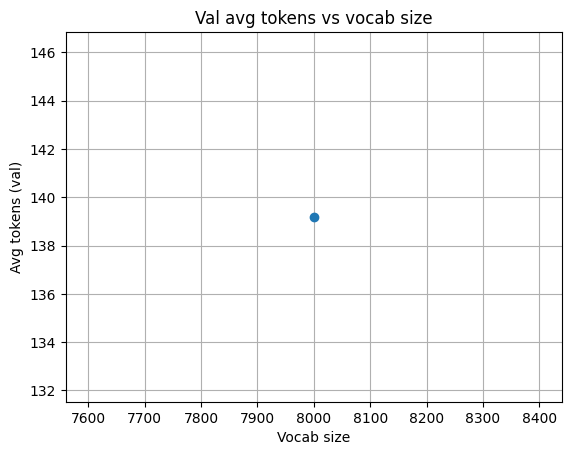

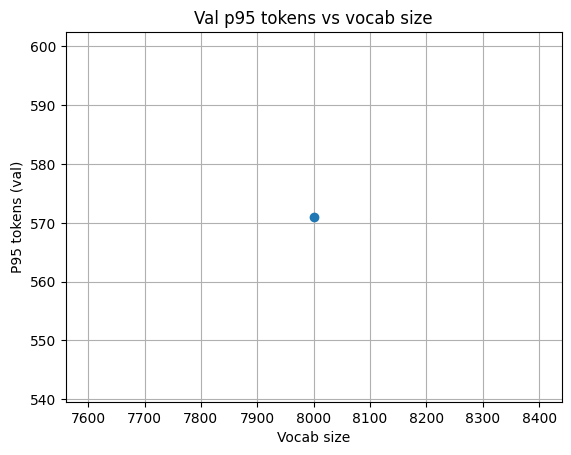

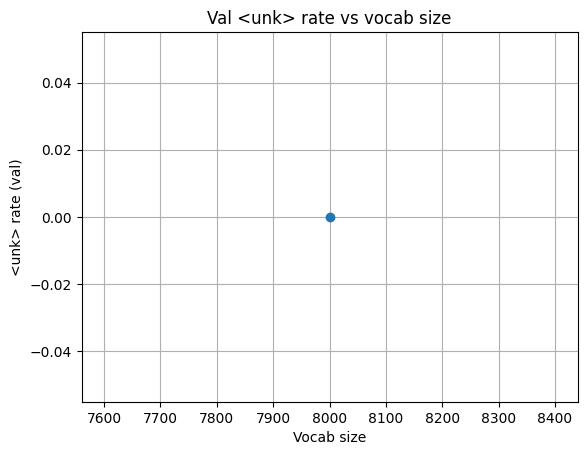


--- Sample encodings @ vocab=8000 ---
LiFePO4              → ['<s>', 'ĠLi', 'F', 'e', 'PO', '4', '</s>']  (len=7)
RNA-seq              → ['<s>', 'ĠRNA', '-', 'se', 'q', '</s>']  (len=6)
μm                   → ['<s>', 'ĠÎ¼m', '</s>']  (len=3)
NaCl                 → ['<s>', 'ĠNa', 'Cl', '</s>']  (len=4)
poly(ethylene)       → ['<s>', 'Ġpoly', '(', 'ethylene', ')', '</s>']  (len=6)
<REFNUM>             → ['<s>', 'Ġ<', 'REFNUM', '>', '</s>']  (len=5)


In [1]:
# Tokenizer Trainer (with metrics & simple viz)
# - Trains byte-level BPE tokenizers over a vocab sweep
# - Logs avg/p95 tokenized lengths and <unk> rate on train/val
# - Saves HF-compatible artifacts per vocab size
# - Visualizes results inline

import json, math, random
from pathlib import Path
from statistics import mean
from typing import List, Dict
from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import Sequence, NFKC
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.processors import TemplateProcessing

# -------------------
# CONFIG (edit here)
# -------------------
TRAIN_TXT = "../data/1-corpus-all-claims/corpus_train.txt"
VAL_TXT   = "../data/1-corpus-all-claims/corpus_val.txt"
OUT_DIR   = "../data/2-tokenizers"   # will create subfolders e.g. vs32000
VOCAB_SIZES = [8000]               # sweep
MIN_FREQ   = 2
SAMPLE_TRAIN = None     # number of lines to sample for quick metrics (None = use all)
SAMPLE_VAL   = None
SEED = 42

# -------------------
# Utilities
# -------------------
def read_lines(path: str, limit: int | None = None) -> List[str]:
    out = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            out.append(line.rstrip("\n"))
            if limit and len(out) >= limit:
                break
    return out

def percentile(xs: List[int], p: float) -> int:
    if not xs: return 0
    xs = sorted(xs); k = (len(xs)-1)*p
    a = math.floor(k); b = math.ceil(k)
    if a == b: return xs[int(k)]
    return int(xs[a] + (xs[b]-xs[a])*(k-a))

def encode_lengths(tok: Tokenizer, lines: List[str]) -> Dict[str, float]:
    unk_id = tok.token_to_id("<unk>")
    lens, unk_tokens = [], 0
    for s in lines:
        enc = tok.encode(s)
        ids = enc.ids
        lens.append(len(ids))
        if unk_id is not None:
            unk_tokens += sum(1 for i in ids if i == unk_id)
    total_tokens = max(1, sum(lens))
    return {
        "n_samples": len(lines),
        "avg_len": float(mean(lens)) if lens else 0.0,
        "p95_len": float(percentile(lens, 0.95)),
        "unk_rate": float(unk_tokens / total_tokens)
    }

def save_hf_artifacts(tok: Tokenizer, outdir: Path):
    outdir.mkdir(parents=True, exist_ok=True)
    tok.save(str(outdir / "tokenizer.json"))
    # minimal HF files
    (outdir / "special_tokens_map.json").write_text(json.dumps({
        "unk_token": "<unk>", "bos_token": "<s>", "eos_token": "</s>",
        "pad_token": "<pad>", "mask_token": "<mask>"
    }, indent=2))
    (outdir / "tokenizer_config.json").write_text(json.dumps({
        "add_prefix_space": True, "model_max_length": 512
    }, indent=2))
    # Export merges/vocab for broader compatibility (best-effort)
    try:
        vocab = tok.get_vocab()  # token->id
        inv = {i:t for t,i in vocab.items()}
        with open(outdir / "vocab.json", "w", encoding="utf-8") as vf:
            ordered = [inv[i] for i in range(len(inv))]
            json.dump({t:i for i,t in enumerate(ordered)}, vf, ensure_ascii=False)
        merges = tok.model.get_merges()
        if merges:
            with open(outdir / "merges.txt", "w", encoding="utf-8") as mf:
                mf.write("#version: 0.2\n")
                for a,b in merges:
                    mf.write(f"{a} {b}\n")
    except Exception:
        pass  # tokenizer.json is typically enough for RobertaTokenizerFast

def train_one(train_file: str, vocab_size: int, min_freq: int, specials: list[str]) -> Tokenizer:
    tok = Tokenizer(BPE(unk_token="<unk>"))
    tok.normalizer = Sequence([NFKC()])
    tok.pre_tokenizer = ByteLevel(add_prefix_space=True)
    tok.decoder = ByteLevelDecoder()
    trainer = BpeTrainer(vocab_size=vocab_size, min_frequency=min_freq, special_tokens=specials)
    tok.train(files=[train_file], trainer=trainer)
    tok.post_processor = TemplateProcessing(
        single="<s> $A </s>",
        pair="<s> $A </s> </s> $B </s>",
        special_tokens=[("<s>", tok.token_to_id("<s>")), ("</s>", tok.token_to_id("</s>"))],
    )
    return tok

# -------------------
# Run sweep
# -------------------
random.seed(SEED)
outbase = Path(OUT_DIR); outbase.mkdir(parents=True, exist_ok=True)
specials = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]

# Sample for quick metrics
train_lines = read_lines(TRAIN_TXT)
val_lines   = read_lines(VAL_TXT)
if SAMPLE_TRAIN and len(train_lines) > SAMPLE_TRAIN:
    train_lines = random.sample(train_lines, SAMPLE_TRAIN)
if SAMPLE_VAL and len(val_lines) > SAMPLE_VAL:
    val_lines = random.sample(val_lines, SAMPLE_VAL)

rows = []
for vs in VOCAB_SIZES:
    print(f"\n=== Training tokenizer (vocab={vs}, min_freq={MIN_FREQ}) ===")
    tok = train_one(TRAIN_TXT, vs, MIN_FREQ, specials)

    m_train = encode_lengths(tok, train_lines)
    m_val   = encode_lengths(tok, val_lines)

    model_dir = outbase / f"vs{vs}"
    save_hf_artifacts(tok, model_dir)
    (model_dir / "meta.json").write_text(json.dumps({
        "vocab_size": vs, "min_freq": MIN_FREQ, "specials": specials,
        "train_file": TRAIN_TXT, "val_file": VAL_TXT,
        "metrics": {"train": m_train, "val": m_val}
    }, indent=2))
    print(f"Saved → {model_dir}")
    print(f"Train: avg={m_train['avg_len']:.2f}, p95={m_train['p95_len']:.0f}, unk_rate={m_train['unk_rate']:.4f}")
    print(f"Val  : avg={m_val['avg_len']:.2f}, p95={m_val['p95_len']:.0f}, unk_rate={m_val['unk_rate']:.4f}")

    rows.append({
        "vocab_size": vs,
        "train_avg_len": m_train["avg_len"],
        "train_p95_len": m_train["p95_len"],
        "train_unk_rate": m_train["unk_rate"],
        "val_avg_len": m_val["avg_len"],
        "val_p95_len": m_val["p95_len"],
        "val_unk_rate": m_val["unk_rate"],
    })

# -------------------
# Tabulate + save summary
# -------------------
df = pd.DataFrame(rows).sort_values("vocab_size")
display(df)

summary_csv = outbase / "summary.csv"
summary_json = outbase / "summary.json"
df.to_csv(summary_csv, index=False)
summary_json.write_text(json.dumps(rows, indent=2))
print(f"\nWrote: {summary_csv}\nWrote: {summary_json}")

# -------------------
# Plots (one metric per plot)
# -------------------
plt.figure()
plt.plot(df["vocab_size"], df["val_avg_len"], marker="o")
plt.title("Val avg tokens vs vocab size")
plt.xlabel("Vocab size"); plt.ylabel("Avg tokens (val)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df["vocab_size"], df["val_p95_len"], marker="o")
plt.title("Val p95 tokens vs vocab size")
plt.xlabel("Vocab size"); plt.ylabel("P95 tokens (val)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df["vocab_size"], df["val_unk_rate"], marker="o")
plt.title("Val <unk> rate vs vocab size")
plt.xlabel("Vocab size"); plt.ylabel("<unk> rate (val)")
plt.grid(True)
plt.show()

# -------------------
# Quick manual tokenization checks (edit terms as needed)
# -------------------
check_terms = ["LiFePO4", "RNA-seq", "μm", "NaCl", "poly(ethylene)", "<REFNUM>"]
for vs in VOCAB_SIZES:
    print(f"\n--- Sample encodings @ vocab={vs} ---")
    tok = Tokenizer.from_file(str((outbase / f"vs{vs}" / "tokenizer.json")))
    for term in check_terms:
        ids = tok.encode(term).ids
        toks = tok.encode(term).tokens
        print(f"{term:20s} → {toks}  (len={len(ids)})")
